In [ ]:
! pip install gdown
! pip install tensorflow==2.19.0
! pip install keras==3.9.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 848.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 74.9 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have te

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score # For final sklearn eval if desired
import pandas as pd
import json
import re

In [ ]:
import gdown
url = 'https://drive.google.com/uc?id=17UHul9LiPWoF5xgZA3OGGhGeTTl2bLWm'
output = 'file.csv'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=17UHul9LiPWoF5xgZA3OGGhGeTTl2bLWm
From (redirected): https://drive.google.com/uc?id=17UHul9LiPWoF5xgZA3OGGhGeTTl2bLWm&confirm=t&uuid=e9a55a3b-c7e8-4391-a239-f942b5473ed4
To: /content/file.csv
100%|██████████| 713M/713M [00:07<00:00, 94.1MB/s]


'file.csv'

In [ ]:
import pandas as pd

df = pd.read_csv('file.csv')

In [ ]:
df.head()

,Unnamed: 0,Review,Label,cleanedtext,decision,finaltext
0,0,I mostly drink English Tea and it is very yumm...,1,mostly drink english tea yummy english tea pre...,1,most drink english tea yummi english tea prett...
1,1,Bought this for a 6 yr old with a sore mouth (...,1,bought yr old sore mouth dental work done love...,1,bought yr old sore mouth dental work done love...
2,2,"I highly recommend this product, I hope they g...",1,highly recommend product hope get back stock s...,1,high recommend product hope get back stock soo...
3,3,I just want to say as well as express my true ...,1,want say well express true satisfaction item s...,1,want say well express true satisfact item serv...
4,4,Click is a wonderful source of protein. Not th...,1,click wonderful source protein not thick clump...,1,click wonder sourc protein not thick clumpi li...


In [ ]:
df = df[['finaltext', 'decision']]

In [ ]:
df.head()

,finaltext,decision
0,most drink english tea yummi english tea prett...,1
1,bought yr old sore mouth dental work done love...,1
2,high recommend product hope get back stock soo...,1
3,want say well express true satisfact item serv...,1
4,click wonder sourc protein not thick clumpi li...,1


In [ ]:
df.dropna(inplace=True)

In [ ]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip glove.6B.300d.txt

In [ ]:
GLOVE_PATH = 'glove.6B.300d.txt' # Make sure this exists
EMBEDDING_DIM = 300
HIDDEN_DIM_LSTM = 128 # Hidden dimension for LSTM cells
MIN_WORD_FREQ = 2
BATCH_SIZE = 32
NUM_EPOCHS = 5 # Can increase this for a simpler model
PATIENCE_ES = 3 # Early stopping patience
LEARNING_RATE = 1e-3

In [ ]:
# --- Tokenizer and Vocab Building ---
def basic_tokenizer(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    return text.split()

data_list = [{"text": str(text), "label": int(label)}
             for text, label in zip(df['finaltext'], df['decision'])]

train_size = int(0.8 * len(data_list))
# val_size = int(0.1 * len(data_list)) # Not explicitly used below for split

# Split data
train_data_list = data_list[:train_size]
remaining_data_list = data_list[train_size:]
val_split_index = int(0.5 * len(remaining_data_list))
val_data_list = remaining_data_list[:val_split_index]
test_data_list = remaining_data_list[val_split_index:]


counter = Counter()
for sample in train_data_list:
    tokens = basic_tokenizer(sample["text"])
    counter.update(tokens)

vocab = {"<pad>": 0, "<unk>": 1}
for word, freq in counter.items():
    if freq >= MIN_WORD_FREQ:
        vocab[word] = len(vocab)

VOCAB_SIZE = len(vocab)
PADDING_IDX = vocab["<pad>"]
UNK_IDX = vocab["<unk>"]
print(f"Vocabulary size: {VOCAB_SIZE} (words occurring >= {MIN_WORD_FREQ} times)")

Vocabulary size: 83595 (words occurring >= 2 times)


In [ ]:
# --- Encode and Pad Data ---
def encode_texts(texts, vocab_map, max_len=None):
    encoded = [[vocab_map.get(token, UNK_IDX) for token in basic_tokenizer(text)] for text in texts]
    if max_len is None:
        max_len = max(len(x) for x in encoded) if encoded else 50 # Default max_len if encoded is empty
    padded = tf.keras.preprocessing.sequence.pad_sequences(
        encoded, maxlen=max_len, padding='post', truncating='post', value=PADDING_IDX
    )
    return padded, max_len

train_texts = [sample['text'] for sample in train_data_list]
train_labels = np.array([sample['label'] for sample in train_data_list], dtype=np.float32)

val_texts = [sample['text'] for sample in val_data_list]
val_labels = np.array([sample['label'] for sample in val_data_list], dtype=np.float32)

test_texts = [sample['text'] for sample in test_data_list]
test_labels = np.array([sample['label'] for sample in test_data_list], dtype=np.float32)

train_padded, MAX_LEN = encode_texts(train_texts, vocab)
print(f"Max sequence length for model input: {MAX_LEN}")

val_padded, _ = encode_texts(val_texts, vocab, max_len=MAX_LEN)
test_padded, _ = encode_texts(test_texts, vocab, max_len=MAX_LEN)

Max sequence length for model input: 1124


In [ ]:
# --- Load GloVe Embeddings ---
def load_glove_embedding_matrix(glove_file_path, vocab_map, embedding_dim, vocab_size_param):
    embeddings_index = {}
    found_in_glove = 0
    try:
        with open(glove_file_path, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.strip().split()
                word = values[0]
                try:
                    vector = np.asarray(values[1:], dtype='float32')
                    if len(vector) == embedding_dim:
                        embeddings_index[word] = vector
                except ValueError:
                    pass
    except FileNotFoundError:
        print(f"Error: GloVe file not found at {glove_file_path}.")
        raise

    embedding_matrix = np.random.uniform(-0.05, 0.05, (vocab_size_param, embedding_dim)).astype(np.float32)
    embedding_matrix[PADDING_IDX] = np.zeros(embedding_dim)

    for word, idx in vocab_map.items():
        if idx < vocab_size_param:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[idx] = embedding_vector
                found_in_glove +=1
    print(f"Initialized GloVe embedding matrix. {found_in_glove}/{len(vocab_map)} words from custom vocab found in GloVe.")
    return embedding_matrix

embedding_matrix_np = load_glove_embedding_matrix(GLOVE_PATH, vocab, EMBEDDING_DIM, VOCAB_SIZE)

Initialized GloVe embedding matrix. 26852/83595 words from custom vocab found in GloVe.


In [ ]:
def build_simple_lstm_model(vocab_s, embedding_d, max_l, lstm_hidden_d, pretrained_embedding_matrix):
    model = keras.Sequential([
        layers.Input(shape=(max_l,), name="input_layer"),
        layers.Embedding(
            input_dim=vocab_s,
            output_dim=embedding_d,
            weights=[pretrained_embedding_matrix],
            input_length=max_l,
            trainable=True,
            mask_zero=True
        ),
        layers.Bidirectional(layers.LSTM(lstm_hidden_d, return_sequences=False)), # return_sequences=False as we take the last output
        layers.BatchNormalization(), # Apply after BiLSTM output
        layers.Dropout(0.5), # Regularization
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid', bias_initializer=tf.keras.initializers.Constant(-1.0)) # Output layer
    ])
    return model

model = build_simple_lstm_model(VOCAB_SIZE, EMBEDDING_DIM, MAX_LEN, HIDDEN_DIM_LSTM, embedding_matrix_np)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1124, 300)      │    25,078,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,535,333 (97.41 MB)

 Trainable params: 25,534,821 (97.41 MB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
# --- Compile Model ---
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# --- Callbacks ---
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_f1_score',
    patience=PATIENCE_ES,
    mode='max',
    restore_best_weights=True
)

In [ ]:
# --- Train Model ---
history = model.fit(
    train_padded,
    train_labels,
    epochs=2,
    batch_size=BATCH_SIZE,
    validation_data=(val_padded, val_labels),
    callbacks=[early_stopping]
)

Epoch 1/2
15627/15627 ━━━━━━━━━━━━━━━━━━━━ 627s 40ms/step - accuracy: 0.9416 - loss: 0.1594 - val_accuracy: 0.9705 - val_loss: 0.0797
Epoch 2/2
    3/15627 ━━━━━━━━━━━━━━━━━━━━ 12:34 48ms/step - accuracy: 0.9809 - loss: 0.0701

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_f1_score` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


15627/15627 ━━━━━━━━━━━━━━━━━━━━ 617s 40ms/step - accuracy: 0.9754 - loss: 0.0694 - val_accuracy: 0.9728 - val_loss: 0.0776


In [ ]:
# --- Evaluate Model ---
print("\nEvaluating on test set...")
loss, accuracy= model.evaluate(test_padded, test_labels, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Evaluating on test set...
Test Loss: 0.0796
Test Accuracy: 0.9725


1954/1954 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step


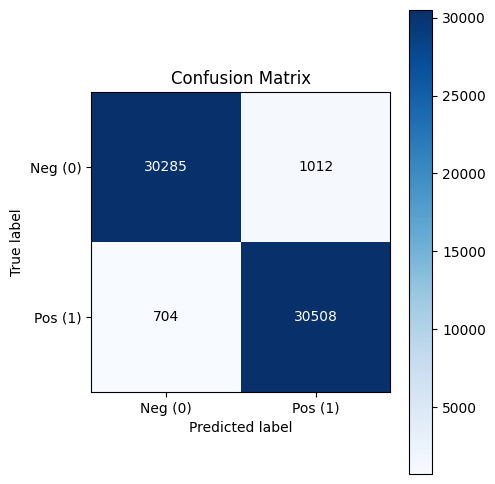

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# --- 1) Get model predictions on your test set ---
y_prob = model.predict(test_padded, batch_size=BATCH_SIZE)
y_pred = (y_prob > 0.5).astype(int).flatten()

# --- 2) Compute the confusion matrix ---
cm = confusion_matrix(test_labels, y_pred)

# --- 3) (Optional) Plot it for clarity ---
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax)
classes = ['Neg (0)', 'Pos (1)']
ax.set(
    xticks=[0,1],
    yticks=[0,1],
    xticklabels=classes,
    yticklabels=classes,
    xlabel='Predicted label',
    ylabel='True label',
    title='Confusion Matrix'
)
# annotate counts in each cell
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha='center', va='center',
                color='white' if cm[i, j] > thresh else 'black')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

# 1) Get predictions on your test set
y_prob = model.predict(test_padded, batch_size=BATCH_SIZE)
y_pred = (y_prob > 0.5).astype(int).flatten()

# 2) Option A: Per‑class metrics via precision_recall_fscore_support
precision, recall, f1, support = precision_recall_fscore_support(
    test_labels,      # true labels (0/1)
    y_pred,           # predicted labels
    labels=[0, 1],    # explicitly for class 0 and class 1
    zero_division=0   # avoids warnings if a class has no predicted samples
)

# 3) Option B: A full text report
print("Detailed classification report:\n")
print(classification_report(
    test_labels,
    y_pred,
    labels=[0, 1],
    target_names=['Class 0 (negative)', 'Class 1 (positive)'],
    zero_division=0
))


1954/1954 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step
Detailed classification report:

                    precision    recall  f1-score   support

Class 0 (negative)       0.98      0.97      0.97     31297
Class 1 (positive)       0.97      0.98      0.97     31212

          accuracy                           0.97     62509
         macro avg       0.97      0.97      0.97     62509
      weighted avg       0.97      0.97      0.97     62509



In [ ]:
import json

# 1. Save the full model (architecture + weights)
model.save('saved_model.keras')
model.save('saved_model.h5')
model.export('saved_model_tf')

# 2. Save your vocab map and config (max_len, pad/unk indices) to JSON
artifacts = {
    'vocab': vocab,
    'max_len': MAX_LEN,
    'pad_idx': PADDING_IDX,
    'unk_idx': UNK_IDX
}
with open('preproc_artifacts.json', 'w', encoding='utf-8') as f:
    json.dump(artifacts, f, ensure_ascii=False, indent=2)

print("Saved model to ./saved_model and preprocessing artifacts to preproc_artifacts.json")


Saved artifact at 'saved_model_tf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1124), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138501877885904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138502563179280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138502563178704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138502563178320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138502563177360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138502563176208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138502563176784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138502563179472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138502563179088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138502563176976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138502563176592: TensorS